In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from Bio import SeqIO
from Bio.SeqIO import SeqRecord
from Bio.Seq import Seq
from matplotlib import pyplot as plt

In [2]:
# Using the post-filtered data here. 
carboxylase_df = pd.read_csv('../annotree_data/PF00016_rubisco_large_042720_not_fIV.csv')
ms_df = pd.read_csv('../annotree_data/PF01274_malate_synthase_042720_filtered.csv')

In [3]:
carboxylase_orgs = set(carboxylase_df.gtdbId.unique())
ms_orgs = set(ms_df.gtdbId.unique())
overlap_orgs = carboxylase_orgs.intersection(ms_orgs)

carboxylase_df['has_malate_synthase'] = [r.gtdbId in ms_orgs for idx, r in carboxylase_df.iterrows()]

n_carboxylase_orgs = len(carboxylase_orgs)
n_with_ms = len(overlap_orgs)
pctage = 100*n_with_ms / n_carboxylase_orgs
print('%.1f%% of %d carboxylase-having organisms also have malate synthase' % (pctage, n_carboxylase_orgs))

49.7% of 2426 carboxylase-having organisms also have malate synthase


In [4]:
# Some groups we thought would contain chemotrophs...
hierarchy = dict(
    phyla=[
        dict(name='Proteobacteria',
             classes=[
                 dict(name='Alphaproteobacteria',
                     orders=[
                         dict(name='Rhizobiales'),
                         dict(name='Rhodobacterales'),
                         dict(name='Rhodospirillales'),
                         dict(name='Rhodospirillales_A'),
                         dict(name='Rhodospirillales_B'),
                         dict(name='Pelagibacterales'),
                         dict(name='Azospirillales'),
                         dict(name='Geminicoccales'),
                         dict(name='Acetobacterales'),
                         dict(name='Caulobacterales'),
                         dict(name='Zavarziniales'),
                         dict(name='Kiloniellales'),
                     ]),
                 dict(name='Gammaproteobacteria',
                      orders=[
                         dict(name='Acidithiobacillales'),
                         dict(name='Burkholderiales'),
                         dict(name='Chromatiales'),
                         dict(name='Thiotrichales'),
                         dict(name='Chromatiales'),
                         dict(name='Enterobacterales'),
                         dict(name='Thiotrichales'),
                         dict(name='Ectothiorhodospirales'),
                         dict(name='Nitrococcales'),
                         dict(name='Xanthomonadales'),
                         dict(name='Pseudomonadales'),
                         dict(name='Nevskiales'),
                         dict(name='Steroidobacterales'),
                         dict(name='Beggiatoales'),
                         dict(name='Legionellales'),
                         dict(name='Thiomicrospirales'),
                         dict(name='Acidiferrobacterales'),
                         dict(name='Granulosicoccales'),
                     ]),
             ]),
        dict(name='Actinobacteriota',
             classes=[
                 dict(name='Actinobacteria',
                      orders=[
                          dict(name='Mycobacteriales'),
                          dict(name='Streptosporangiales'),
                          dict(name='Actinomycetales'),
                          dict(name='Streptomycetales'),
                          dict(name='Propionibacteriales'),
                      ])
             ]),
        dict(name='Firmicutes',
             classes=[
                dict(name='Alicyclobacillia',
                      orders=[
                          dict(name='Alicyclobacillales'),
                      ]),
                 dict(name='Clostridia',
                      orders=[
                          dict(name='Clostridiales'),
                      ]),
                 dict(name='Sulfobacillia',
                      orders=[
                          dict(name='Sulfobacillales'),
                      ]),
             ]),
        dict(name='Cyanobacteria', 
             classes=[
                 dict(name='Cyanobacteriia')
             ]),
    ])

In [5]:
def retrieve_counts(df, key, value):
    mask = df[key] == value
    unique_orgs = df[mask].gtdbId.unique().size
    
    has_ms_mask = mask & df.has_malate_synthase
    unique_orgs_with_ms = carboxylase_df[has_ms_mask].gtdbId.unique().size
    
    return unique_orgs, unique_orgs_with_ms
    

ntot = []
pct_w_ms = []
colors = []
names = []

pal = sns.color_palette('muted')
cmap = dict(phylum=pal[0], cls=pal[1], order=pal[2])

for ph in hierarchy['phyla']:
    n, n_w_ms = retrieve_counts(carboxylase_df, 'phylum_', ph['name'])
    ntot.append(n)
    pct_w_ms.append(100*n_w_ms/n)
    colors.append(cmap['phylum'])
    names.append(ph['name'])
    
    for cl in ph.get('classes', []):
        n, n_w_ms = retrieve_counts(carboxylase_df, 'class', cl['name'])
        if n < 5:
            continue
        ntot.append(n)
        pct_w_ms.append(100*n_w_ms/n)
        colors.append(cmap['cls'])
        names.append(cl['name'])
        
        for ordr in cl.get('orders', []):
            n, n_w_ms = retrieve_counts(carboxylase_df, 'order', ordr['name'])
            if n < 5:
                continue
            ntot.append(n)
            pct_w_ms.append(100*n_w_ms/n)
            colors.append(cmap['order'])
            names.append(ordr['name'])

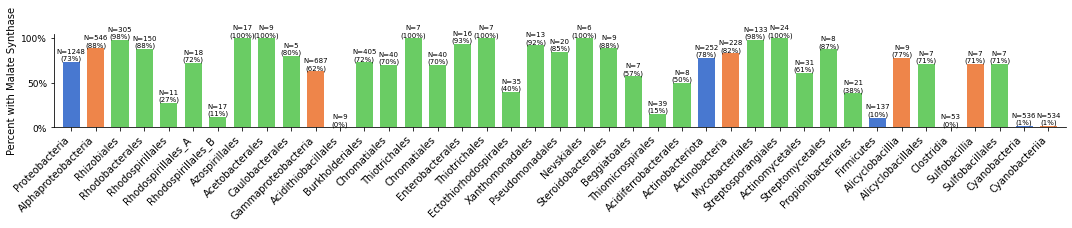

In [6]:
fig = plt.figure(figsize=(15, 3))
pal = sns.color_palette('muted')

xs = np.arange(len(pct_w_ms))
plt.bar(xs, pct_w_ms, color=colors, width=0.7)
for x, y, count in zip(xs, pct_w_ms, ntot):
    plt.text(x, y+2, 'N=%d\n(%d%%)' % (count, y), ha='center', fontsize=7)

plt.xticks(xs, names, rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('Percent with Malate Synthase')

ys = np.arange(0, 101, 50)
plt.yticks(ys, ['%d%%' % y for y in ys], fontsize=9)
plt.ylim(0, 105)
plt.xlim(-0.7, len(pct_w_ms)-0.3)

sns.despine()
plt.tight_layout()
plt.savefig('ms.png', dpi=300)
plt.show()

In [7]:
deduped_carboxylase_df = carboxylase_df.drop_duplicates('gtdbId').copy()
deduped_carboxylase_df.to_csv('species_level_data.csv')
deduped_carboxylase_df['n_with_rubisco'] = np.ones(deduped_carboxylase_df.has_malate_synthase.size)
counts_by_order_df = deduped_carboxylase_df.groupby('domain,phylum,order'.split(',')).sum()
counts_by_order_df['malate_synthase_fraction'] = counts_by_order_df.has_malate_synthase / counts_by_order_df.n_with_rubisco

output_cols = ['n_with_rubisco', 'has_malate_synthase', 'malate_synthase_fraction']
counts_by_order_df[output_cols].to_csv('summary_by_order.csv')


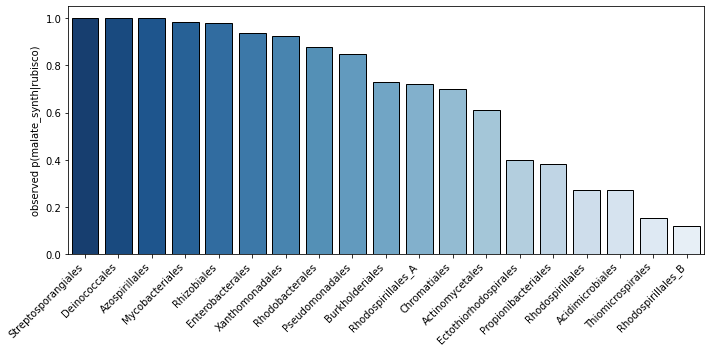

In [8]:
mask = counts_by_order_df.n_with_rubisco > 10
mask = np.logical_and(mask, counts_by_order_df.malate_synthase_fraction >= 0.05)
masked_df = counts_by_order_df[mask]

masked_df = masked_df.reset_index()
masked_df.sort_values('malate_synthase_fraction', inplace=True, ascending=False)


plt.figure(figsize=(10,5))
sns.barplot(data=masked_df, x='order', y='malate_synthase_fraction', palette=sns.color_palette('Blues_r', n_colors=20), edgecolor='k')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('observed p(malate_synth|rubisco)')
plt.tight_layout()
plt.savefig('ms2.png', dpi=150)
plt.show()